<a href="https://colab.research.google.com/github/Ken-huea/image-recognition/blob/main/cifer10_%E7%94%BB%E5%83%8F%E5%A2%97%E6%AE%96_%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNNと分類

今回は少ないデータでも画像を水増しして学習させるというコンセプトで行います。
少ない画像数を水増しして補っていこうという事ですね。

簡単な流れはこちらです。

① cifar10から訓練画像データを取得

② そのデータをビジュアルにて確認。plt.imshow()

③ 水増し/正規化の独自関数を作成し画像を突っ込む。
その際に、for文で回したり等工夫を行うと宜し。

④画像が増える。トレインデータの水増し＆質の向上。

⑤ラベルデータの増殖も行う。

⑥水増しされた画像を、CNNモデル学習用に整形。⇒<font color="red">注:</font>学習に用いる
水増しした画像はトレインデータにのみ用いる事。

テストデータは本当にテストに用いるべきものである。
水増しされた画像をテストデータに用いるとカンニングでしょう。

### データ準備と分割

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

ここで今回はインポートするデータを<font color="red">極端に少なくします</font>。

そして画像データを増殖するという事は正解ラベルも増殖するという事です。
増殖した後に正解ラベルをカテゴリカル分類致しましょう。


In [2]:
# データのロード。してトレインとテスト分割
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# トレインデータ(極少)をダウンロード。
X_train = X_train[:1000]
y_train =y_train[:1000]


# テストデータをダウンロード
X_test = X_test[:50]
y_test =y_test[:50]


#  正解ラベルもダウンロード。
# y_train =y_train[:5]
# y_test =y_test[:5]

# データセットの個数を表示し確認。
print(X_train.shape[0], 'train samples')
print(y_train.shape[0], 'test samples')

print(X_test.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')

# 正解ラベルも確認致しましょう。
# print("これらがy_testの正解ラベル\n",y_test)

170508288/170498071 [==============================] - 11s 0us/step
1000 train samples
1000 test samples
50 train samples
50 test samples


ロードした今回扱うデータを確認してみましょう。

In [3]:
# データの形状(ピクセル数等)の確認 ⇒ (32, 32, 3)
print(X_train[1].shape)

# 画像をビジュアルにて確認
# その為のモジュールをインポート
from google.colab.patches import cv2_imshow
import cv2

# for文を用いて一括確認。更にリサイズして大きさも見やすく調整。⇒時間がかかります。
# for im in X_train:
#   cv2_imshow(cv2.resize(im,(100,100)))

(32, 32, 3)


### データの増殖
確認が済んだところで実際に増殖してみましょう。


### データの増殖


① cifar10から訓練画像データを取得

② そのデータをビジュアルにて確認。plt.imshow()

③ 水増し/正規化の独自関数を作成し画像を突っ込む。
その際に、for文で回したり等工夫を行うと宜し。

④画像が増える。トレインデータの水増し＆質の向上。

⑤ラベルデータの増殖も行う。⇒男女識別の添削課題を参照。

⑥水増しされた画像を、CNNモデル学習用に整形。⇒学習に用いる
水増しした画像はトレインデータにのみ用いる事。

テストデータは本当にテストに用いるべきものである。
水増しされた画像をテストデータに用いるとカンニングでしょう。

そのデータを増殖させる独自関数はこちら


In [ ]:
import cv2
import os

def scratch_image(img, flip=True, thr=True, blur=True, resize=True, erode=True):
    # 水増しの手法を配列にまとめる
    methods = [flip, thr, blur, resize, erode]
    # 画像のサイズを習得、ぼかしに使うフィルターの作成
    img_size = img.shape
    filter1 = np.ones((3, 3))              # 多分カーネルの引数の事？
    # オリジナルの画像データを配列に格納
    images = [img]
    # 手法に用いる関数
    scratch = np.array([
        lambda x: cv2.flip(x, 1),                                     # 引数xのをflipします。
        lambda x: cv2.threshold(x, 100, 255, cv2.THRESH_TOZERO)[1],   # 閾値(しきいち)処理
        lambda x: cv2.GaussianBlur(x, (5, 5), 0),                     # GaussianBlur:ぼかし処理　resize:モザイク処理。縮小⇒拡大の動作の事。
        lambda x: cv2.resize(cv2.resize(
                        x, (img_size[1] // 5, img_size[0] // 5)
                    ),(img_size[1], img_size[0])),
        lambda x: cv2.erode(x, filter1)                               # 収縮処理
    ])
    # 関数と画像を引数に、加工した画像を元と合わせて水増しする関数
    
    doubling_images = lambda f, imag: (imag + [f(i) for i in imag])
    # methodsがTrueの関数で水増し
    for func in scratch[methods]:
        images = doubling_images(func, images)
    
    return images

In [ ]:
    # 画像の読み込み
# img9 = cv2.imread("/content/9.jpg")

scratched_images = [] # 水増し画像をいれる箱。
scratched_labels = [] # 水増し画像の正解ラベルをいれる箱。
multiplied_label = 32 # 水増しされるラベルの数。1枚が32枚に水増しされるので *32倍する為の物。

# ① imgとlabelにそれぞれの画像と正解ラベルを格納します。
# ② imgに独自関数"scratch_image"を噛ませます⇒増殖。それをリストscratched_imagesに格納。
# ③ labelを水増しした分、掛けます。今回は1枚が32枚に水増しされるので *32 しています。

for img,label in zip (X_train, y_train):                # ①
  scratched_images += scratch_image(img)                # ②
  scratched_labels += [label] * multiplied_label        # ③

# 水増しされた画像とラベルを確認しましょう。
print("水増しされた結果の画像の合計：",len(scratched_images))
print("水増しされた結果のラベルの合計：",len(scratched_labels))

水増しされた結果の画像の合計： 32000
水増しされた結果のラベルの合計： 32000


In [ ]:
# 保存したいときは保存の処理を行う。
# 画像を保存するフォルダーを作成
if not os.path.exists("scratch_images"):
  os.mkdir("scratch_images")

for num, im in enumerate(scratched_images):
  cv2.imwrite("scratch_images/" + str(num) + ".jpg" ,im)

### データ整形。
次はデータ整形をしましょう。　まずは増殖されたデータの確認。


In [ ]:
# 水増しされた画像とラベルを確認しましょう。⇒訓練データにて使用。
print("水増しされた結果の画像の合計：",len(scratched_images))
print("水増しされた結果のラベルの合計：",len(scratched_labels))

水増しされた結果の画像の合計： 32000
水増しされた結果のラベルの合計： 32000


増殖した画像データはリストなのでnumpyに変換します。


増殖した正解ラベルをカテゴリカル(one hot encording)に変換します。



In [ ]:
# 水増しした画像データをX_trainにコピｰ＆ペースト
X_train =scratched_images.copy() 

print(X_train[0].shape) # これはまだリストなので…

# リスト⇒numpy配列に変換。
X_train = np.array(X_train)

# 確認
print(type(X_train))

# 正解ラベルをone hot encordingに変換。
y_train = to_categorical(scratched_labels)
print(y_train[0]) # 水増ししたラベルがちゃんとone hot encordingされている事を確認。

(32, 32, 3)
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


callbackにてX_testとy_testも使用するので整形しておきます。

In [ ]:
y_test = to_categorical(y_test)
print(y_test)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0.

In [ ]:
# カラム数が統一されているかの確認
print(y_train.shape) # (1600, 10)
print(y_test.shape)  # (50, 10)

(32000, 10)
(50, 10)


### CNN作成と学習
増殖させた訓練データを用いて学習させてみましょう。


モデルの構築を行います。

In [ ]:
# モデルの定義
model = Sequential()

# 畳み込み開始。　入力層・
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))

# 畳み込み層
    # 入力データにカーネルをかける（「3×3」の32種類のフィルタを使う）⇒それで結局、
    # 出力ユニット数：32（64枚分の出力データが得られる）。画像の特徴量が表すデータ。
    # 問題が複雑ならフィルタの種類を増やす
    # 他パラメータは前回で定義されているので自動的にそれに従ってくれている。
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

  # 【プーリング層】:特徴量を圧縮する層。（ロバスト性向上、過学習防止、計算コスト抑制のため）
    # 実際に位置が若干ズレていたとしても対応､融通が利くように。画像の空間サイズを小さくし、調整するパラメーター数も減少⇒過学習を防止。
    # pool_size=(2, 2):入力画像内の「2×2」の領域で最大の数値を出力。⇒"Max Pooling"
model.add(MaxPooling2D(pool_size=(2, 2)))

    # ドロップアウト(過学習防止用, dropout_rate=0.2なら20%のユニットを無効化）
model.add(Dropout(0.25))

# ここから
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Dropout(0.25))
# ここまで。

    # 平坦化（次元削減）⇒ 1次元ベクトルに変換。畳み込み時には多次元でしたが、最終的な出力は1次元です。これの処理。
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

    # 全結合層
  # 10分類（0から9まで）なので、ユニット数10, 分類問題なので活性化関数はsoftmax関数
  # Softmax関数で総和が1となるように、各出力の予測確率を計算
  # 例「0.7, 0, 0, 0, 0, 0, 0.2, 0, 0, 0.1」（0の確率70%, 6の確率20%, 9の確率10%, 他0%）
model.add(Dense(10))


model.add(Activation('softmax'))


# コンパイル
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# 重みデータ param_cifar10.hdf5 を読み込みます
# model.load_weights('./param_cifar10.hdf5')

In [ ]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=300, 

    validation_data=(X_test, y_test),        # コールバックする際はvalidation dataも準備する。
    callbacks=[
        callbacks.EarlyStopping(monitor='val_accuracy',patience=20),
        callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_accuracy', save_best_only=True)
        ]
)

# loss 数値
# acuracy 分類
# balidationのテストがちゃんと変換されているか確認してみて。

Epoch 1/300
4000/4000 [==============================] - 229s 57ms/step - loss: 2.2153 - accuracy: 0.3012 - val_loss: 1.7990 - val_accuracy: 0.3000
Epoch 2/300
4000/4000 [==============================] - 225s 56ms/step - loss: 1.6565 - accuracy: 0.4100 - val_loss: 1.5689 - val_accuracy: 0.4800
Epoch 3/300
4000/4000 [==============================] - 226s 56ms/step - loss: 1.5519 - accuracy: 0.4555 - val_loss: 1.6897 - val_accuracy: 0.4200
Epoch 4/300
4000/4000 [==============================] - 226s 56ms/step - loss: 1.4577 - accuracy: 0.4899 - val_loss: 1.6310 - val_accuracy: 0.4600
Epoch 5/300
4000/4000 [==============================] - 227s 57ms/step - loss: 1.3776 - accuracy: 0.5225 - val_loss: 1.5803 - val_accuracy: 0.3800
Epoch 6/300
4000/4000 [==============================] - 225s 56ms/step - loss: 1.3194 - accuracy: 0.5434 - val_loss: 1.7427 - val_accuracy: 0.3600
Epoch 7/300
4000/4000 [==============================] - 227s 57ms/step - loss: 1.2628 - accuracy: 0.5633 - val_

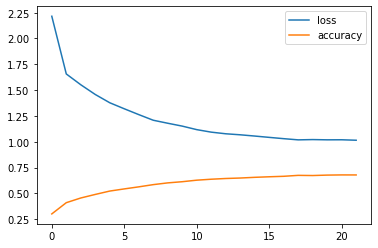

In [ ]:
# 訓練データの学習過程のプロット
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["accuracy"], label="accuracy")
plt.legend()

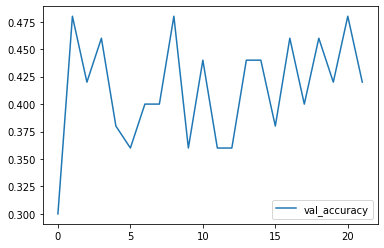

In [ ]:
# valデータではどうなっているかも確認 ⇒ 全然だめですね。val_accurancyがちっとも上がっていない。
import matplotlib.pyplot as plt
import seaborn as sns
# plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")

plt.legend()

### 精度評価と考察

###### 精度の予測

In [ ]:
# 精度の評価
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# 良くはないね

2/2 [==============================] - 0s 26ms/step - loss: 1.6684 - accuracy: 0.4200
Test loss: 1.6683958768844604
Test accuracy: 0.41999998688697815


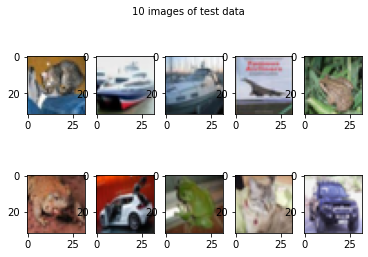

2/2 [==============================] - 0s 27ms/step - loss: 1.6684 - accuracy: 0.4200
これが予測値です [2 8 1 8 6 6 5 4 3 1]
これが実測値です [3 8 8 0 6 6 1 6 3 1]
これが正解率です 0.5


In [ ]:
# データの可視化（検証データの先頭の10枚）
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
plt.suptitle("10 images of test data",fontsize=10)
plt.show()

# 予測（検証データの先頭の10枚）
pred = np.argmax(model.predict(X_test[0:10]), axis=1)

# 実測値(y_test)
acutal = np.argmax(y_test[0:10], axis=1)

# 正解率
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred,acutal)

scores = model.evaluate(X_test, y_test, verbose=1)
print("これが予測値です",pred)
print("これが実測値です",acutal)
print("これが正解率です",acc)

###### 考察

- モデル構築に工夫を加えて少ないデータでも良いモデルを作るのか。

- 当初の目標である<font color="red">画像データを水増しして学習させる</font>という目標は達成できた。　
しかし結果はやはり奮わなかった。しかしアイデアを実現させて実装し確認できたので良し。

画像の増殖方法をより工夫すれば良いモデルが作成できるのか、いつか確かめてみたい。

- 本当に効果を確かめるには

①5万枚の画像データにて訓練したモデル

②1万枚の画像データを5万枚の画像データにしてそれを元に訓練したモデル

双方の違いはデータのみでモデル構築/学習は一緒。その２つを比較考量する。

そのぐらいの手間をかければ画像増殖の有効性を確認できる可能性はあります。
時間あるときに上記の比較が出来ればと。